In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow.compat.v2 as tf
from tensorflow.keras import utils
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import pandas as pd

In [2]:
dataset, info = tfds.load('caltech_birds2010', with_info=True)

In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
#     input_mask -= 1
    return input_image, input_mask

In [4]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [5]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [8]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

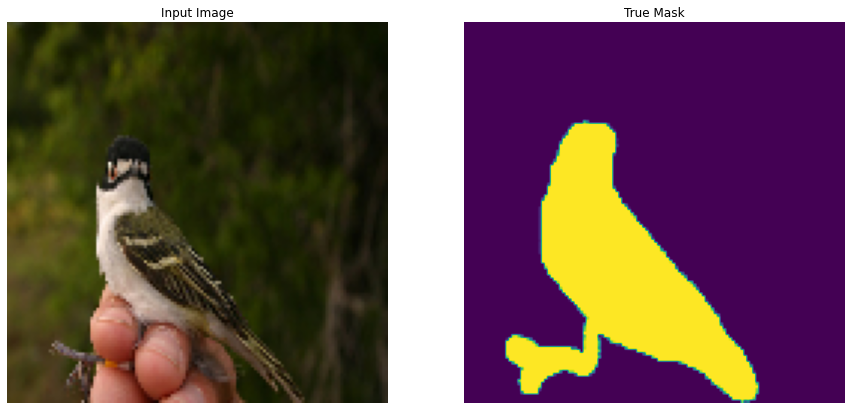

In [10]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

### Model

In [11]:
OUTPUT_CHANNELS = 3

#### encoder

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

#### decoder

In [13]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

#### model combine

In [14]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.save_weights('model.h5')

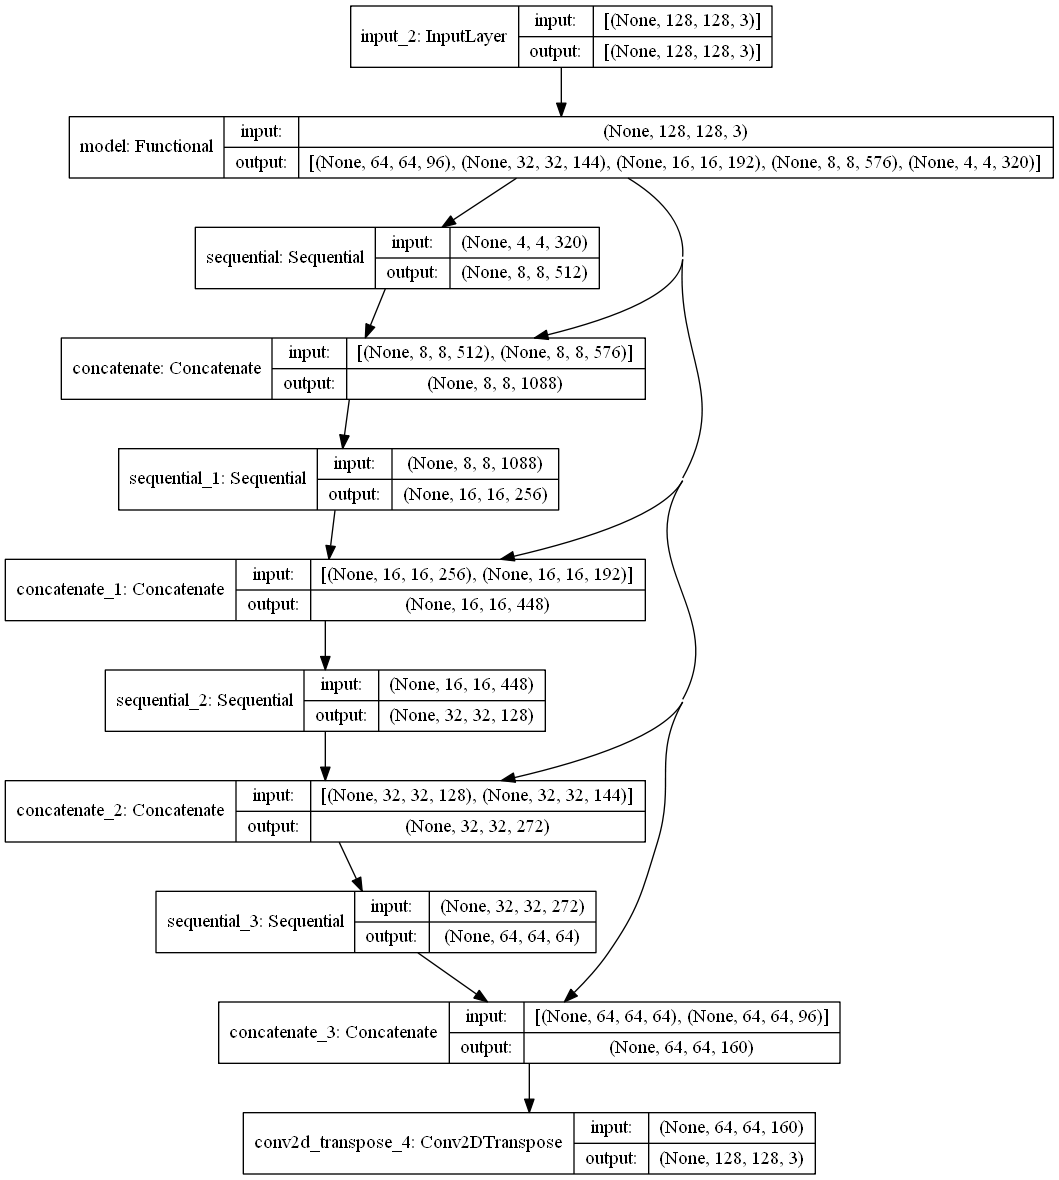

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [18]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

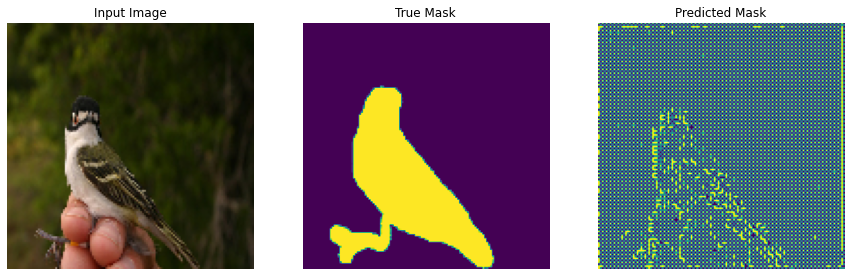

In [19]:
show_predictions() #до обучения

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

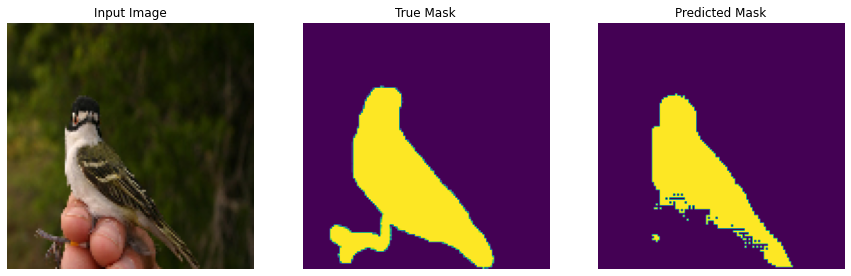


Sample Prediction after epoch 5



In [21]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()]
                         )

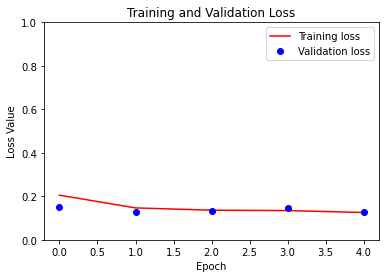

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [23]:
res = {}
res['as_is'] = [loss[-1], val_loss[-1]]
pd.DataFrame.from_dict(res, orient='index', columns = ['train_loss', 'val_loss'])

,train_loss,val_loss
as_is,0.125474,0.126229


#### BATCH_SIZE

Изменим steps_per_epoch и validation_steps посредством изменения batch_size

In [24]:
%%time #45 min
for bs in [8, 32, 64]:
    VALIDATION_STEPS = info.splits['test'].num_examples // bs // VAL_SUBSPLITS
    STEPS_PER_EPOCH = TRAIN_LENGTH // bs
    
    model.load_weights('model.h5')
    model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
#                           callbacks=[DisplayCallback()]
                         )
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    res['bs_' + str(bs)] = [loss[-1], val_loss[-1]]

Epoch 1/5
375/375 [==============================] - 378s 1s/step - loss: 0.1707 - accuracy: 0.9283 - val_loss: 0.1803 - val_accuracy: 0.9211
Epoch 2/5
375/375 [==============================] - 376s 1s/step - loss: 0.1333 - accuracy: 0.9426 - val_loss: 0.1327 - val_accuracy: 0.9429
Epoch 3/5
375/375 [==============================] - 378s 1s/step - loss: 0.1224 - accuracy: 0.9464 - val_loss: 0.1256 - val_accuracy: 0.9452
Epoch 4/5
375/375 [==============================] - 376s 1s/step - loss: 0.1113 - accuracy: 0.9508 - val_loss: 0.1252 - val_accuracy: 0.9466
Epoch 5/5
375/375 [==============================] - 399s 1s/step - loss: 0.1020 - accuracy: 0.9546 - val_loss: 0.1317 - val_accuracy: 0.9462
Epoch 1/5
93/93 [==============================] - 97s 1s/step - loss: 0.2330 - accuracy: 0.9048 - val_loss: 0.4644 - val_accuracy: 0.8354
Epoch 2/5
93/93 [==============================] - 94s 1s/step - loss: 0.1568 - accuracy: 0.9336 - val_loss: 0.1467 - val_accuracy: 0.9392
Epoch 3/5
93

In [25]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_loss', 'val_loss'])

,train_loss,val_loss
as_is,0.125474,0.126229
bs_8,0.101991,0.131721
bs_32,0.140000,0.129413
bs_64,0.151482,0.132037


На трейне уменьшение размера батча приводит к снижению лосса, но на валидации особой разницы (и закономерности) нет

### layers

#### reduce layers

In [26]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_12_project',  # 8x8
#     'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [27]:
up_stack = [
#     pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [28]:
model2 = unet_model(OUTPUT_CHANNELS)
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model2.save_weights('model2.h5')

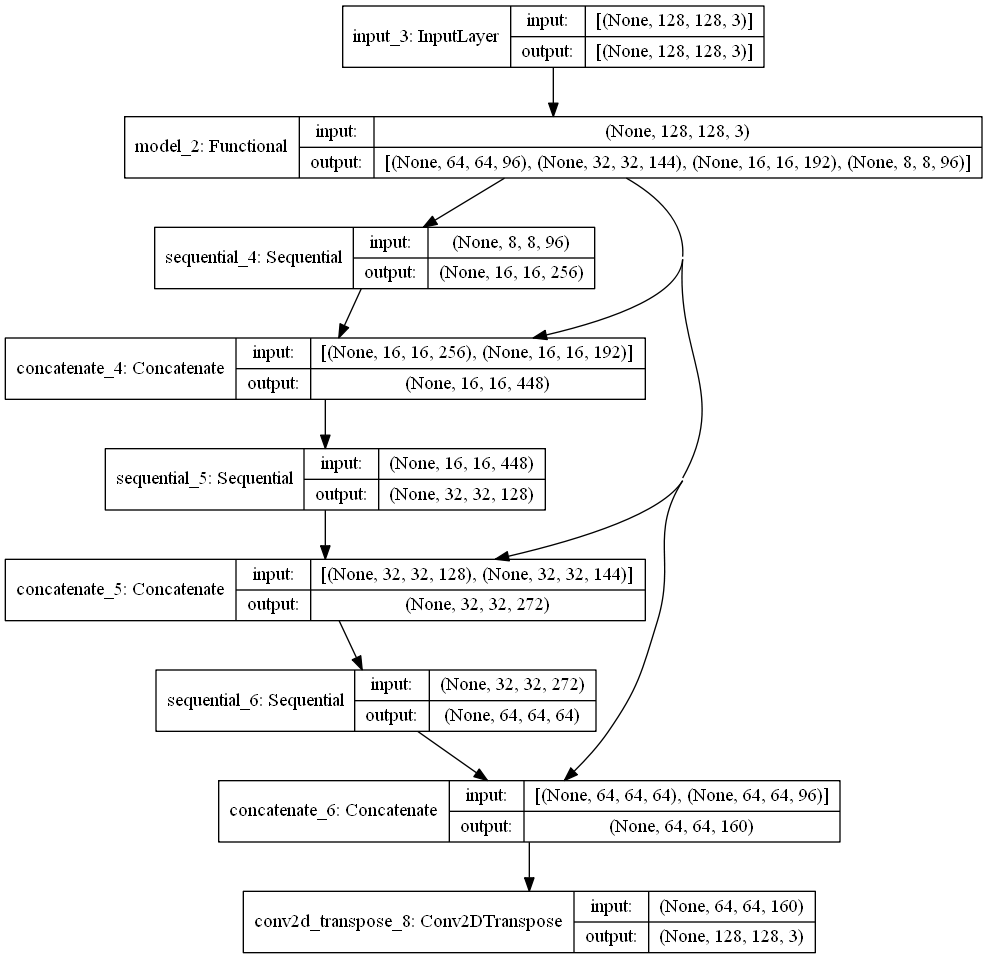

In [29]:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [30]:
bs = 16
VALIDATION_STEPS = info.splits['test'].num_examples // bs // VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // bs

# model.load_weights('model.h5')
model_history = model.fit(train_dataset, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_steps=VALIDATION_STEPS,
                      validation_data=test_dataset,
#                           callbacks=[DisplayCallback()]
                     )
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
res['layers'] = [loss[-1], val_loss[-1]]

Epoch 1/5
187/187 [==============================] - 185s 991ms/step - loss: 0.1442 - accuracy: 0.9383 - val_loss: 0.1876 - val_accuracy: 0.9192
Epoch 2/5
187/187 [==============================] - 185s 993ms/step - loss: 0.1355 - accuracy: 0.9416 - val_loss: 0.1406 - val_accuracy: 0.9387
Epoch 3/5
187/187 [==============================] - 187s 1s/step - loss: 0.1296 - accuracy: 0.9437 - val_loss: 0.1292 - val_accuracy: 0.9432
Epoch 4/5
187/187 [==============================] - 186s 993ms/step - loss: 0.1238 - accuracy: 0.9460 - val_loss: 0.1331 - val_accuracy: 0.9425
Epoch 5/5
187/187 [==============================] - 186s 995ms/step - loss: 0.1180 - accuracy: 0.9482 - val_loss: 0.1428 - val_accuracy: 0.9387


In [31]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_loss', 'val_loss'])

,train_loss,val_loss
as_is,0.125474,0.126229
bs_8,0.101991,0.131721
bs_32,0.140000,0.129413
bs_64,0.151482,0.132037
layers,0.118020,0.142806


Получили чуть меньший лосс на трейне и хуже на валидации (возможно, случайно)

#### add layers

In [32]:
# Use the activations of these layers
layer_names = [
    'Conv1_relu',
    'expanded_conv_depthwise_BN',
    'block_1_expand',
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_12_project',  # 8x8
#     'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [33]:
up_stack = [
#     pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [34]:
model3 = unet_model(OUTPUT_CHANNELS)
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model3.save_weights('model3.h5')

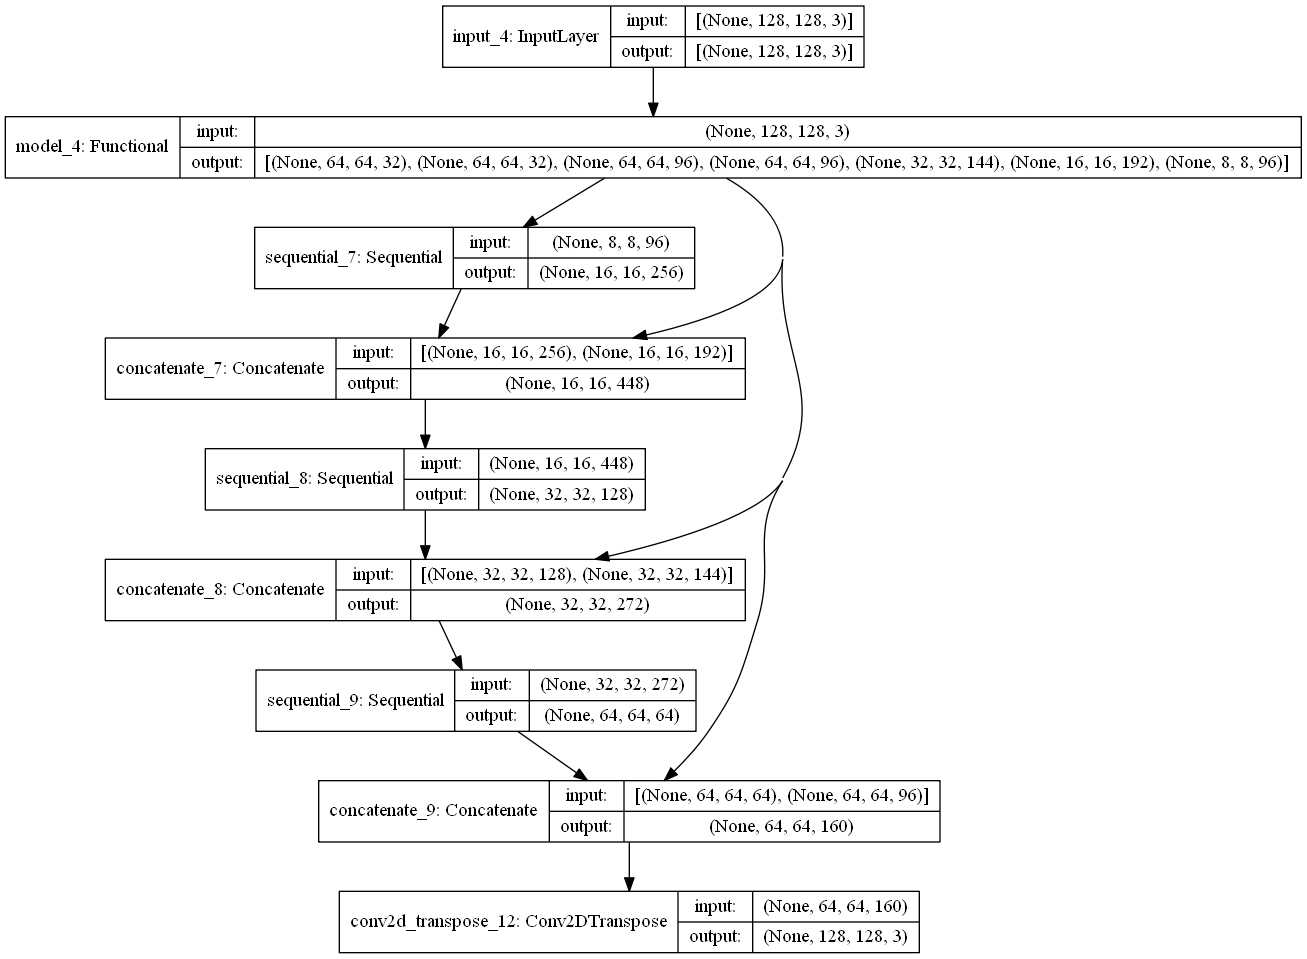

In [35]:
tf.keras.utils.plot_model(model3, show_shapes=True)

In [36]:
model_history = model3.fit(train_dataset, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_steps=VALIDATION_STEPS,
                      validation_data=test_dataset,
#                           callbacks=[DisplayCallback()]
                     )
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
res['add_layers'] = [loss[-1], val_loss[-1]]

Epoch 1/5
187/187 [==============================] - 136s 720ms/step - loss: 0.3362 - accuracy: 0.8605 - val_loss: 0.1763 - val_accuracy: 0.9233
Epoch 2/5
187/187 [==============================] - 133s 711ms/step - loss: 0.1726 - accuracy: 0.9255 - val_loss: 0.1611 - val_accuracy: 0.9305
Epoch 3/5
187/187 [==============================] - 132s 707ms/step - loss: 0.1661 - accuracy: 0.9280 - val_loss: 0.1563 - val_accuracy: 0.9308
Epoch 4/5
187/187 [==============================] - 132s 708ms/step - loss: 0.1592 - accuracy: 0.9311 - val_loss: 0.1454 - val_accuracy: 0.9361
Epoch 5/5
187/187 [==============================] - 139s 744ms/step - loss: 0.1587 - accuracy: 0.9312 - val_loss: 0.1483 - val_accuracy: 0.9344


In [37]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_loss', 'val_loss'])

,train_loss,val_loss
as_is,0.125474,0.126229
bs_8,0.101991,0.131721
bs_32,0.140000,0.129413
bs_64,0.151482,0.132037
layers,0.118020,0.142806
add_layers,0.155516,0.148335


Добавление слоев и с этой  стороны только ухудшило результат

### epochs

Посмотрим, как поведет себя каждая модель с увеличением количества эпох

In [38]:
BATCH_SIZE = 16
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [39]:
model.load_weights('model.h5')
model_history = model.fit(train_dataset, epochs=20,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_steps=VALIDATION_STEPS,
                      validation_data=test_dataset,
#                           callbacks=[DisplayCallback()]
                     )
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
res['model1'] = [loss[-1], val_loss[-1]]

Epoch 1/20
187/187 [==============================] - 195s 1s/step - loss: 0.1991 - accuracy: 0.9175 - val_loss: 0.1438 - val_accuracy: 0.9385
Epoch 2/20
187/187 [==============================] - 193s 1s/step - loss: 0.1459 - accuracy: 0.9379 - val_loss: 0.1656 - val_accuracy: 0.9265
Epoch 3/20
187/187 [==============================] - 187s 1s/step - loss: 0.1382 - accuracy: 0.9404 - val_loss: 0.1323 - val_accuracy: 0.9424
Epoch 4/20
187/187 [==============================] - 186s 997ms/step - loss: 0.1317 - accuracy: 0.9429 - val_loss: 0.1363 - val_accuracy: 0.9423
Epoch 5/20
187/187 [==============================] - 187s 999ms/step - loss: 0.1263 - accuracy: 0.9450 - val_loss: 0.1272 - val_accuracy: 0.9461
Epoch 6/20
187/187 [==============================] - 187s 999ms/step - loss: 0.1219 - accuracy: 0.9467 - val_loss: 0.1375 - val_accuracy: 0.9421
Epoch 7/20
187/187 [==============================] - 186s 996ms/step - loss: 0.1159 - accuracy: 0.9491 - val_loss: 0.1250 - val_accu

In [40]:
model2.load_weights('model2.h5')
model_history2 = model2.fit(train_dataset, epochs=20,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_steps=VALIDATION_STEPS,
                      validation_data=test_dataset,
#                           callbacks=[DisplayCallback()]
                     )
loss2 = model_history2.history['loss']
val_loss2 = model_history2.history['val_loss']
res['model2'] = [loss2[-1], val_loss2[-1]]

Epoch 1/20
187/187 [==============================] - 139s 736ms/step - loss: 0.3336 - accuracy: 0.8610 - val_loss: 0.1599 - val_accuracy: 0.9305
Epoch 2/20
187/187 [==============================] - 137s 734ms/step - loss: 0.1770 - accuracy: 0.9233 - val_loss: 0.1619 - val_accuracy: 0.9307
Epoch 3/20
187/187 [==============================] - 136s 730ms/step - loss: 0.1695 - accuracy: 0.9259 - val_loss: 0.1591 - val_accuracy: 0.9316
Epoch 4/20
187/187 [==============================] - 137s 730ms/step - loss: 0.1641 - accuracy: 0.9289 - val_loss: 0.1477 - val_accuracy: 0.9348
Epoch 5/20
187/187 [==============================] - 137s 735ms/step - loss: 0.1555 - accuracy: 0.9328 - val_loss: 0.1448 - val_accuracy: 0.9367
Epoch 6/20
187/187 [==============================] - 136s 730ms/step - loss: 0.1567 - accuracy: 0.9323 - val_loss: 0.1422 - val_accuracy: 0.9373
Epoch 7/20
187/187 [==============================] - 136s 726ms/step - loss: 0.1509 - accuracy: 0.9343 - val_loss: 0.1395 -

In [41]:
model3.load_weights('model3.h5')
model_history3 = model3.fit(train_dataset, epochs=20,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_steps=VALIDATION_STEPS,
                      validation_data=test_dataset,
#                           callbacks=[DisplayCallback()]
                     )
loss3 = model_history3.history['loss']
val_loss3 = model_history3.history['val_loss']
res['model3'] = [loss3[-1], val_loss3[-1]]

Epoch 1/20
187/187 [==============================] - 137s 732ms/step - loss: 0.2239 - accuracy: 0.9063 - val_loss: 0.1663 - val_accuracy: 0.9281
Epoch 2/20
187/187 [==============================] - 138s 738ms/step - loss: 0.1748 - accuracy: 0.9241 - val_loss: 0.1540 - val_accuracy: 0.9324
Epoch 3/20
187/187 [==============================] - 137s 733ms/step - loss: 0.1637 - accuracy: 0.9287 - val_loss: 0.1582 - val_accuracy: 0.9296
Epoch 4/20
187/187 [==============================] - 137s 734ms/step - loss: 0.1609 - accuracy: 0.9303 - val_loss: 0.1453 - val_accuracy: 0.9368
Epoch 5/20
187/187 [==============================] - 136s 730ms/step - loss: 0.1578 - accuracy: 0.9315 - val_loss: 0.1465 - val_accuracy: 0.9366
Epoch 6/20
187/187 [==============================] - 137s 732ms/step - loss: 0.1512 - accuracy: 0.9345 - val_loss: 0.1409 - val_accuracy: 0.9389
Epoch 7/20
187/187 [==============================] - 137s 735ms/step - loss: 0.1482 - accuracy: 0.9357 - val_loss: 0.1388 -

In [46]:
pd.DataFrame.from_dict(res, orient='index', columns = ['train_loss', 'val_loss'])

,train_loss,val_loss
as_is,0.125474,0.126229
bs_8,0.101991,0.131721
bs_32,0.140000,0.129413
bs_64,0.151482,0.132037
layers,0.118020,0.142806
add_layers,0.155516,0.148335
model1,0.059351,0.167661
model2,0.126179,0.135850
model3,0.127385,0.135475


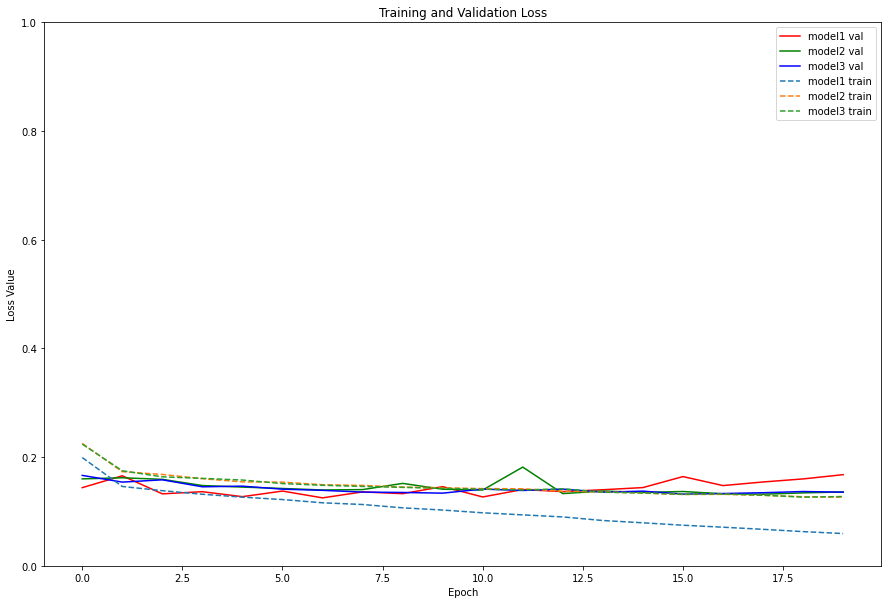

In [58]:
epochs = range(20)

plt.figure(figsize=(15, 10))
plt.plot(epochs, val_loss, 'r', label='model1 val')
plt.plot(epochs, val_loss2, 'g', label='model2 val')
plt.plot(epochs, val_loss3, 'b', label='model3 val')
plt.plot(epochs, loss, '--', label='model1 train')
plt.plot(epochs, loss2, '--', label='model2 train')
plt.plot(epochs, loss3, '--', label='model3 train')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Третья модель показывает самый стабильные результаты как на трейне, так и на валидации

### prediction

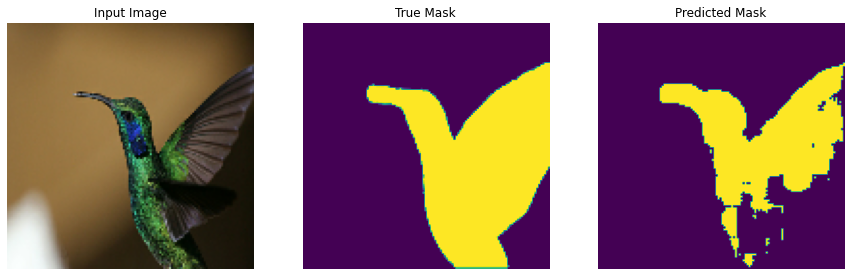

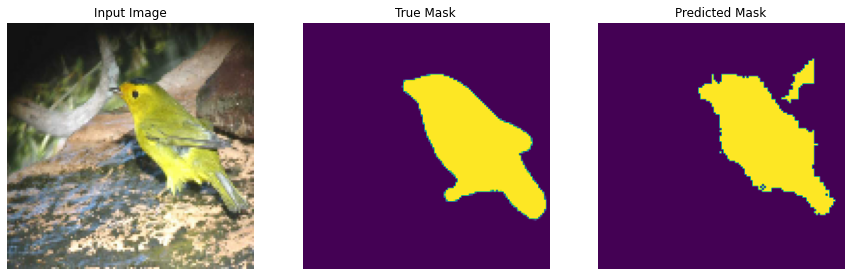

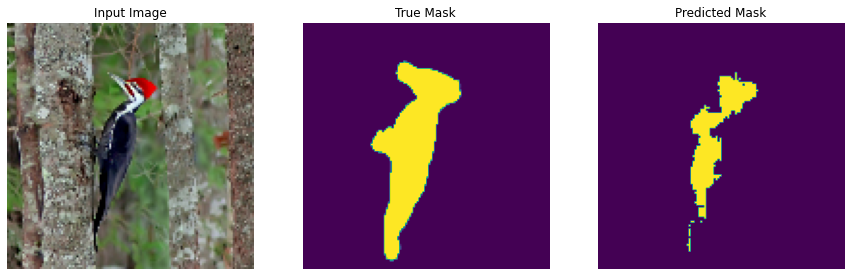

In [60]:
for image, mask in test_dataset.take(3):
            pred_mask = model3.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])